# Basic Anomaly Detection for Cybersecurity Logs (Synthetic Dataset)

This notebook builds a small end-to-end anomaly detection pipeline for cybersecurity-style logs, including:

- **Dataset generation** (synthetic login + network-like fields)
- **EDA**
- **Isolation Forest** anomaly detection (with proper preprocessing)
- **2D projection (PCA)** and anomaly visualization
- **Conclusion**

**MITRE ATT&CK technique covered:**  
- **T1110 – Brute Force** (many failed login attempts and unusual patterns)
- *(optional interpretation)* **T1078 – Valid Accounts** (successful but suspicious logins at unusual hours/locations)

---


In [2]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

# Reproducibility
RANDOM_STATE = 42
rng = np.random.default_rng(RANDOM_STATE)


## 1) Prepare a cybersecurity-related dataset (Synthetic)

We generate a synthetic **login event** dataset with these columns:

- Time-based feature: `hour`
- Numeric features: `duration_sec`, `bytes_sent`, `failed_attempts_last_10m`
- Categorical features: `user`, `src_country`, `protocol`
- Optional evaluation label: `label` (0=normal, 1=attack)

**Anomalies (~2%)** represent **Brute Force (T1110)** patterns, such as:
- Elevated `failed_attempts_last_10m`
- Off-hours activity (late night / early morning)
- Unusual geography or protocol mix
- Slightly longer durations and/or abnormal bytes behavior


In [4]:

def generate_synthetic_cyber_logs(n_rows=12000, anomaly_ratio=0.02, random_state=42):
    rng = np.random.default_rng(random_state)
    
    n_anom = int(n_rows * anomaly_ratio)
    n_norm = n_rows - n_anom
    
    # Categorical pools
    users = [f"user_{i:02d}" for i in range(1, 21)]  # 20 users
    countries_common = ["IL", "US", "DE", "FR", "UK", "NL"]
    countries_rare = ["RU", "CN", "IR", "KP"]  # 'rare' geos for anomalies
    protocols = ["SSH", "RDP", "HTTPS"]
    
    # -------- Normal behavior --------
    # Hours: mostly work hours + evening
    hour_norm = np.clip(np.round(rng.normal(loc=14, scale=4, size=n_norm)).astype(int), 0, 23)
    
    # Duration (seconds): short typical sessions
    duration_norm = np.clip(rng.lognormal(mean=2.0, sigma=0.35, size=n_norm), 2, 300)  # ~7s to ~300s
    
    # Bytes sent: modest with occasional medium; log-normal
    bytes_norm = np.clip(rng.lognormal(mean=9.0, sigma=0.6, size=n_norm), 200, 300000).astype(int)
    
    # Failed attempts in last 10 minutes: mostly 0-1
    failed_norm = rng.poisson(lam=0.25, size=n_norm)
    
    user_norm = rng.choice(users, size=n_norm, replace=True, p=None)
    country_norm = rng.choice(countries_common, size=n_norm, replace=True, p=[0.45, 0.15, 0.12, 0.10, 0.10, 0.08])
    protocol_norm = rng.choice(protocols, size=n_norm, replace=True, p=[0.55, 0.20, 0.25])
    
    df_norm = pd.DataFrame({
        "hour": hour_norm,
        "duration_sec": duration_norm,
        "bytes_sent": bytes_norm,
        "failed_attempts_last_10m": failed_norm,
        "user": user_norm,
        "src_country": country_norm,
        "protocol": protocol_norm,
        "label": np.zeros(n_norm, dtype=int)
    })
    
    # -------- Anomalous behavior (T1110 Brute Force) --------
    # Hours: off-hours concentrated (0-5, 22-23)
    off_hours = np.array([0,1,2,3,4,5,22,23])
    hour_anom = rng.choice(off_hours, size=n_anom, replace=True, p=[0.12,0.14,0.14,0.14,0.12,0.10,0.12,0.12])
    
    # Brute force: high failed attempts
    failed_anom = np.clip(rng.poisson(lam=12, size=n_anom) + rng.integers(0, 8, size=n_anom), 6, 40)
    
    # Duration: sometimes longer (retries / automation), but still bounded
    duration_anom = np.clip(rng.lognormal(mean=2.4, sigma=0.5, size=n_anom), 3, 600)
    
    # Bytes: can be low (failed auth) OR weird spikes (tooling/noise)
    mix = rng.random(n_anom)
    bytes_anom = np.where(
        mix < 0.75,
        rng.integers(50, 900, size=n_anom),                     # mostly tiny bytes during failed attempts
        rng.integers(250000, 1200000, size=n_anom)              # occasional spikes
    ).astype(int)
    
    # Target fewer users to mimic account targeting
    targeted_users = rng.choice(users, size=5, replace=False)
    user_anom = rng.choice(targeted_users, size=n_anom, replace=True)
    
    country_anom = rng.choice(countries_rare + countries_common, size=n_anom, replace=True,
                              p=[0.22, 0.22, 0.20, 0.06, 0.12, 0.08, 0.05, 0.03, 0.02, 0.00])[:n_anom]
    # (Above p vector length may be off if edited; ensure correct below)
    
    # Correct country sampling robustly:
    all_countries = countries_rare + countries_common
    p = np.array([0.22, 0.22, 0.20, 0.06, 0.12, 0.08, 0.05, 0.03, 0.02, 0.00], dtype=float)
    p = p[:len(all_countries)]
    p = p / p.sum()
    country_anom = rng.choice(all_countries, size=n_anom, replace=True, p=p)
    
    # Protocol: more SSH/RDP in brute force attempts
    protocol_anom = rng.choice(protocols, size=n_anom, replace=True, p=[0.70, 0.25, 0.05])
    
    df_anom = pd.DataFrame({
        "hour": hour_anom,
        "duration_sec": duration_anom,
        "bytes_sent": bytes_anom,
        "failed_attempts_last_10m": failed_anom,
        "user": user_anom,
        "src_country": country_anom,
        "protocol": protocol_anom,
        "label": np.ones(n_anom, dtype=int)
    })
    
    # Combine and shuffle
    df = pd.concat([df_norm, df_anom], ignore_index=True)
    df = df.sample(frac=1.0, random_state=random_state).reset_index(drop=True)
    
    # Round duration for readability
    df["duration_sec"] = df["duration_sec"].round(2)
    return df

df = generate_synthetic_cyber_logs(n_rows=12000, anomaly_ratio=0.02, random_state=RANDOM_STATE)
df.head()


,hour,duration_sec,bytes_sent,failed_attempts_last_10m,user,src_country,protocol,label
0,20,4.06,14094,0,user_20,IL,SSH,0
1,14,6.78,13323,0,user_02,US,SSH,0
2,18,6.90,4264,0,user_02,IL,SSH,0
3,16,8.47,3403,0,user_08,IL,HTTPS,0
4,13,8.51,24882,0,user_01,IL,HTTPS,0


## 2) Exploratory Data Analysis (EDA)

We compute basic stats and plot at least two visualizations:
- Histograms for numeric features
- Count plots for categorical features
- Time-based distribution (logins per hour)

Then we provide a short analytical summary.


In [6]:

# Basic dataset statistics
n_rows, n_cols = df.shape
print("Rows:", n_rows)
print("Features:", n_cols)
print("\nClass distribution (label):")
print(df["label"].value_counts())
print("\nClass distribution (%):")
print((df["label"].value_counts(normalize=True) * 100).round(2))


Rows: 12000
Features: 8

Class distribution (label):
label
0    11760
1      240
Name: count, dtype: int64

Class distribution (%):
label
0    98.0
1     2.0
Name: proportion, dtype: float64


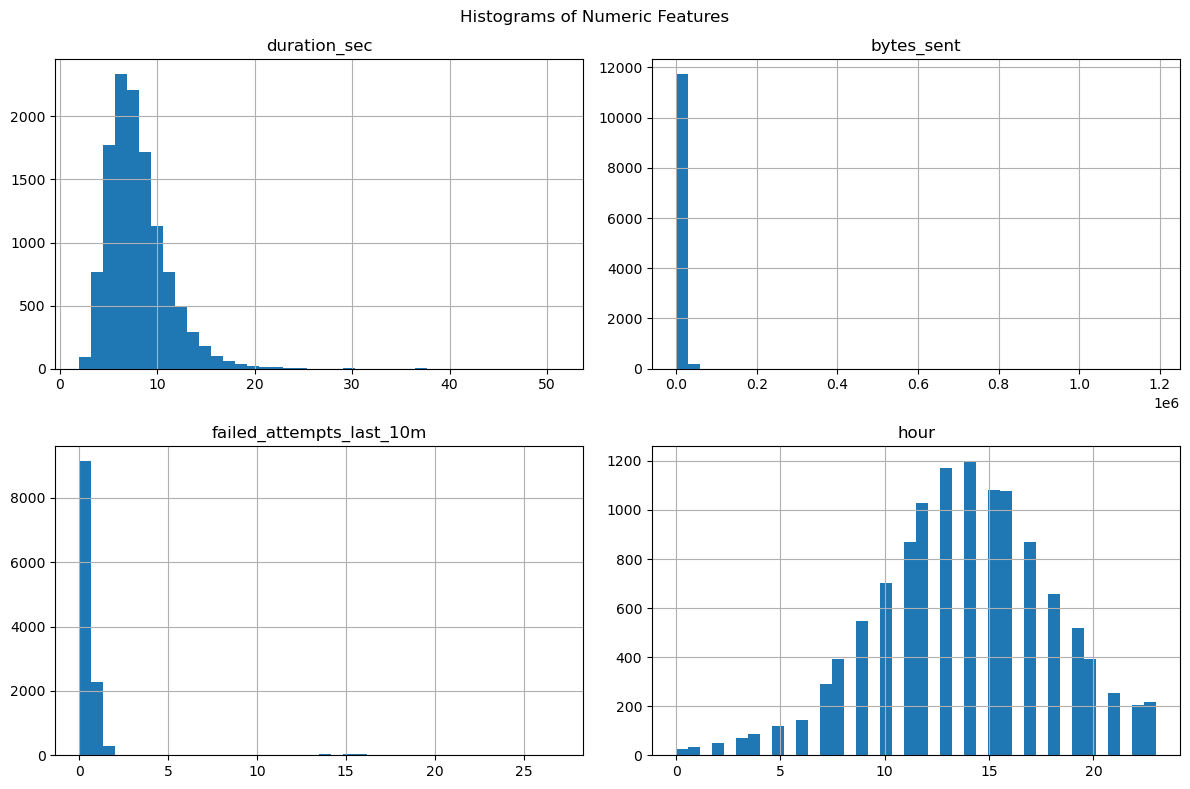

In [7]:

# Numeric feature histograms
numeric_cols = ["duration_sec", "bytes_sent", "failed_attempts_last_10m", "hour"]

df[numeric_cols].hist(bins=40, figsize=(12, 8))
plt.suptitle("Histograms of Numeric Features")
plt.tight_layout()
plt.show()


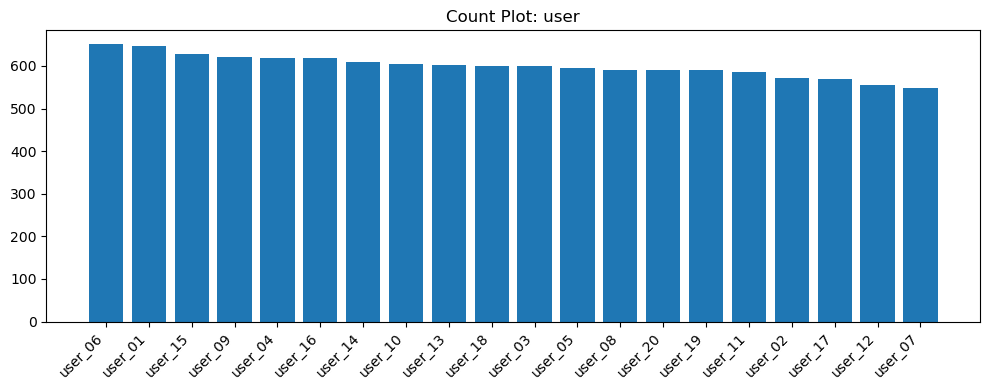

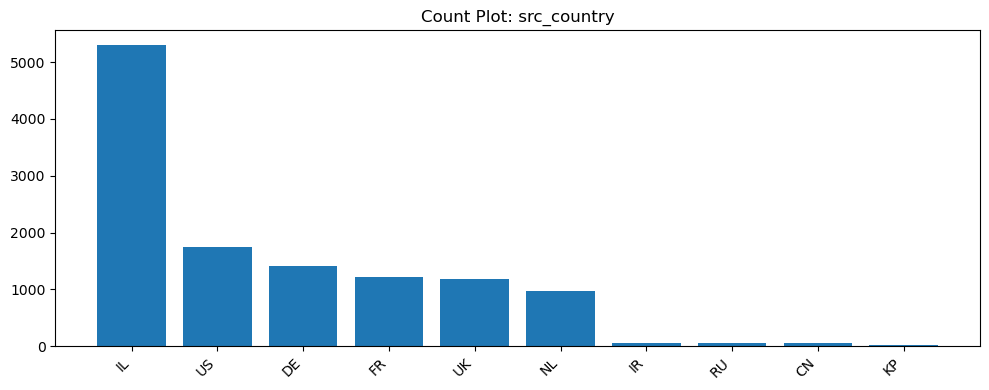

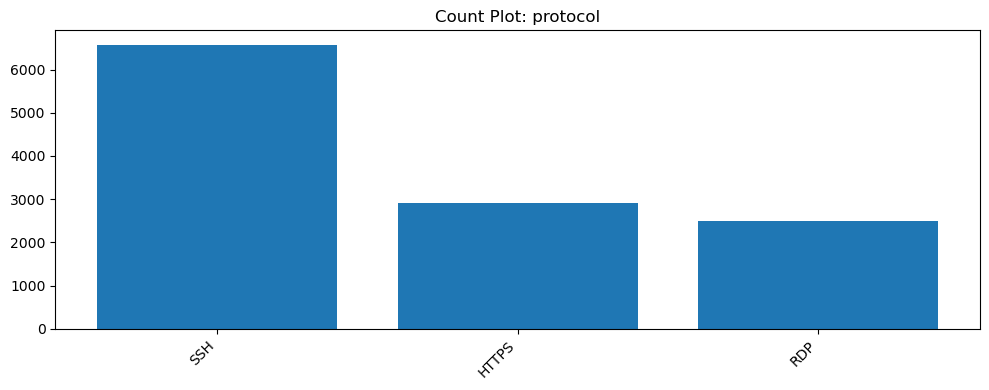

In [8]:

# Count plots for categorical features (simple matplotlib-based counts)
cat_cols = ["user", "src_country", "protocol"]

for col in cat_cols:
    counts = df[col].value_counts()
    plt.figure(figsize=(10, 4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(f"Count Plot: {col}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


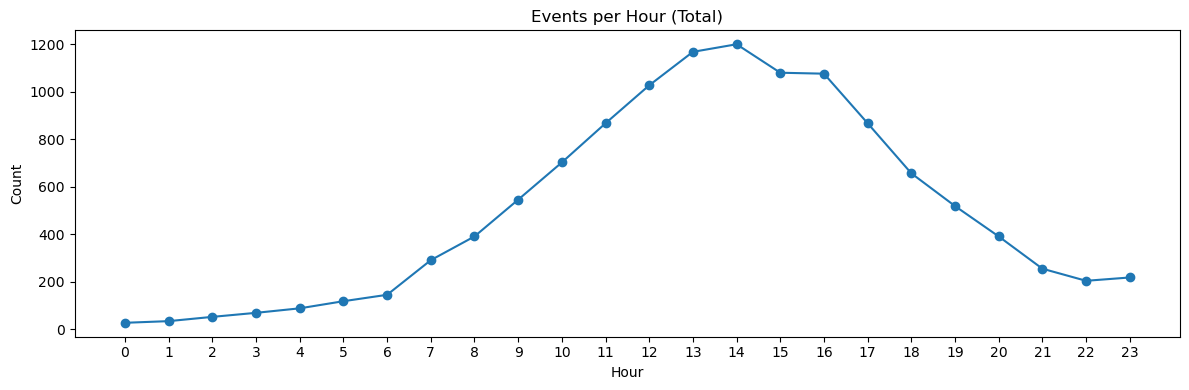

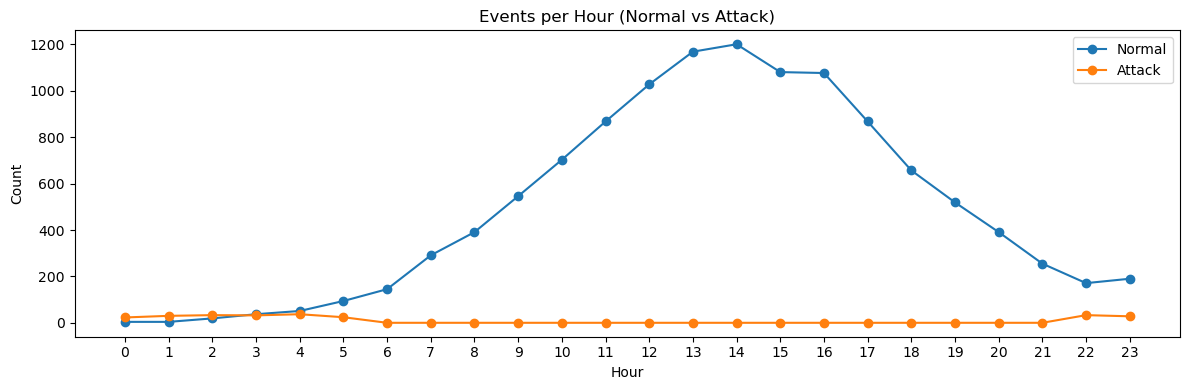

In [9]:

# Time-based distribution: events per hour (and compare normal vs attack)
hour_counts_total = df["hour"].value_counts().sort_index()
hour_counts_norm = df[df["label"] == 0]["hour"].value_counts().sort_index()
hour_counts_anom = df[df["label"] == 1]["hour"].value_counts().sort_index()

hours = np.arange(24)
total = hour_counts_total.reindex(hours, fill_value=0).values
norm = hour_counts_norm.reindex(hours, fill_value=0).values
anom = hour_counts_anom.reindex(hours, fill_value=0).values

plt.figure(figsize=(12, 4))
plt.plot(hours, total, marker="o")
plt.title("Events per Hour (Total)")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(hours)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(hours, norm, marker="o", label="Normal")
plt.plot(hours, anom, marker="o", label="Attack")
plt.title("Events per Hour (Normal vs Attack)")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.xticks(hours)
plt.legend()
plt.tight_layout()
plt.show()


### Analytical summary (3–5 sentences)

In this synthetic dataset, most normal logins occur around typical daytime and evening hours, with short-to-moderate session durations and modest byte volumes. Failed login attempts within a 10-minute window are usually near zero in normal behavior. We expect anomalies to appear as **off-hours activity** combined with **high failed-attempt counts**, consistent with **T1110 (Brute Force)**. Additionally, anomalies may show unusual country/protocol combinations and atypical byte patterns (very low bytes for failures, or occasional spikes). These patterns should be separable by an unsupervised detector like Isolation Forest.


## 3) Apply an Anomaly Detection Model (Isolation Forest)

We will:
- Encode categorical features (OneHotEncoder)
- Scale numeric features (StandardScaler)
- Train Isolation Forest
- Extract anomaly scores and predicted labels
- Evaluate (scores histogram + anomaly count + metrics using ground truth label)


In [12]:

# Features
feature_cols = ["hour", "duration_sec", "bytes_sent", "failed_attempts_last_10m", "user", "src_country", "protocol"]
target_col = "label"

X = df[feature_cols].copy()
y = df[target_col].copy()  # for evaluation only

numeric_features = ["hour", "duration_sec", "bytes_sent", "failed_attempts_last_10m"]
categorical_features = ["user", "src_country", "protocol"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ],
    remainder="drop"
)

# Isolation Forest: contamination ~ expected anomaly fraction
contamination = 0.02

iso = IsolationForest(
    n_estimators=300,
    contamination=contamination,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("iso", iso)
])

model


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour', 'duration_sec',
                                                   'bytes_sent',
                                                   'failed_attempts_last_10m']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['user', 'src_country',
                                                   'protocol'])])),
                ('iso',
                 IsolationForest(contamination=0.02, n_estimators=300,
                                 n_jobs=-1, random_state=42))])

In [13]:

# Train Isolation Forest (unsupervised)
model.fit(X)

# Scores: decision_function -> higher means more normal; lower means more anomalous
scores = model.named_steps["iso"].decision_function(model.named_steps["preprocess"].transform(X))

# Predictions: IsolationForest returns 1 for inliers, -1 for outliers
pred_raw = model.named_steps["iso"].predict(model.named_steps["preprocess"].transform(X))
pred_anom = (pred_raw == -1).astype(int)  # 1=anomaly, 0=normal

df_results = df.copy()
df_results["anomaly_score"] = scores
df_results["pred_anomaly"] = pred_anom

df_results.head()


,hour,duration_sec,bytes_sent,failed_attempts_last_10m,user,src_country,protocol,label,anomaly_score,pred_anomaly
0,20,4.06,14094,0,user_20,IL,SSH,0,0.077542,0
1,14,6.78,13323,0,user_02,US,SSH,0,0.056046,0
2,18,6.90,4264,0,user_02,IL,SSH,0,0.075761,0
3,16,8.47,3403,0,user_08,IL,HTTPS,0,0.063531,0
4,13,8.51,24882,0,user_01,IL,HTTPS,0,0.051953,0


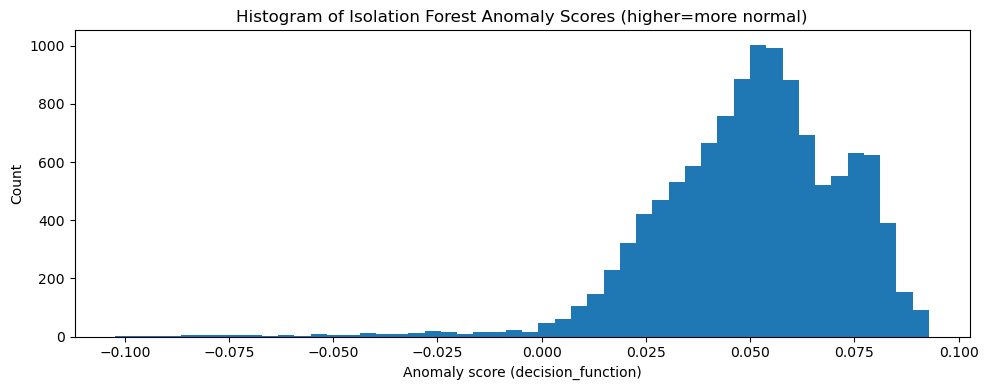

Detected anomalies: 240 (2.00%)


In [14]:

# Histogram of anomaly scores
plt.figure(figsize=(10, 4))
plt.hist(df_results["anomaly_score"], bins=50)
plt.title("Histogram of Isolation Forest Anomaly Scores (higher=more normal)")
plt.xlabel("Anomaly score (decision_function)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# How many anomalies detected
detected = df_results["pred_anomaly"].sum()
print("Detected anomalies:", detected, f"({detected/len(df_results)*100:.2f}%)")


In [15]:

# Evaluation with ground truth label (optional but recommended)
acc = accuracy_score(y, pred_anom)
prec = precision_score(y, pred_anom, zero_division=0)
rec = recall_score(y, pred_anom, zero_division=0)

print("Accuracy:", round(acc, 4))
print("Precision:", round(prec, 4))
print("Recall:", round(rec, 4))
print("\nConfusion Matrix [ [TN, FP], [FN, TP] ]:")
print(confusion_matrix(y, pred_anom))

print("\nClassification Report:")
print(classification_report(y, pred_anom, digits=4))


Accuracy: 0.9947
Precision: 0.8667
Recall: 0.8667

Confusion Matrix [ [TN, FP], [FN, TP] ]:
[[11728    32]
 [   32   208]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9973    0.9973    0.9973     11760
           1     0.8667    0.8667    0.8667       240

    accuracy                         0.9947     12000
   macro avg     0.9320    0.9320    0.9320     12000
weighted avg     0.9947    0.9947    0.9947     12000



## 4) Visualize anomalies on a 2D projection (PCA)

We apply PCA on the **preprocessed feature space** (scaled numerics + one-hot categories) and plot the first two principal components.

We color points by:
- predicted anomaly label (normal vs anomaly)
- (optionally) score intensity can be added, but label coloring is enough for the assignment.


In [17]:

# Transform X into the model's feature space
X_transformed = model.named_steps["preprocess"].transform(X)

# PCA to 2D
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d = pca.fit_transform(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed)

print("Explained variance ratio:", pca.explained_variance_ratio_, " (sum=", pca.explained_variance_ratio_.sum(), ")")


Explained variance ratio: [0.25358235 0.15278006]  (sum= 0.40636240944225716 )


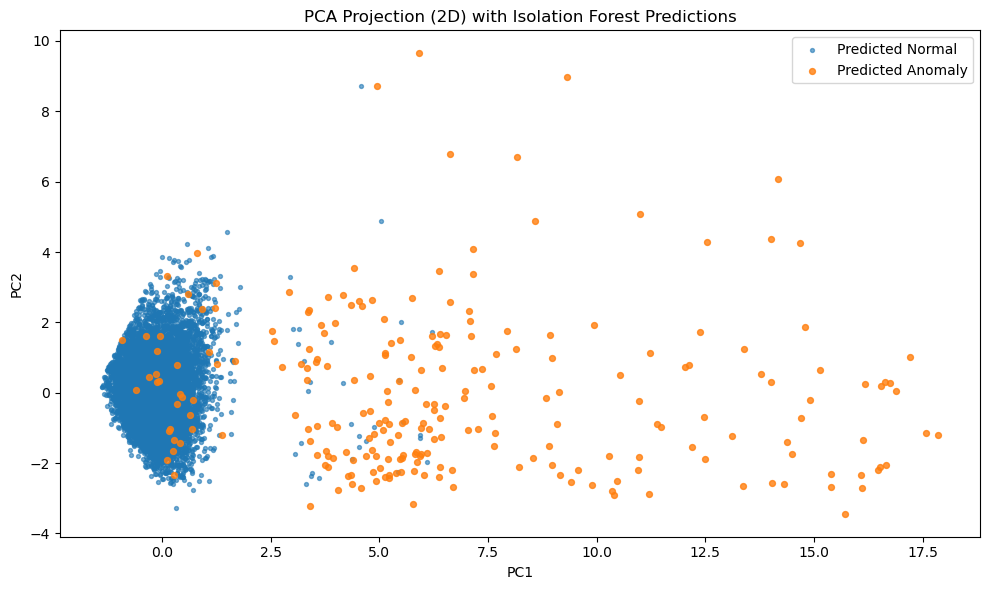

In [18]:

# 2D scatter plot colored by predicted anomalies
plt.figure(figsize=(10, 6))
mask_anom = df_results["pred_anomaly"] == 1

plt.scatter(X_2d[~mask_anom, 0], X_2d[~mask_anom, 1], s=8, alpha=0.6, label="Predicted Normal")
plt.scatter(X_2d[mask_anom, 0], X_2d[mask_anom, 1], s=18, alpha=0.8, label="Predicted Anomaly")

plt.title("PCA Projection (2D) with Isolation Forest Predictions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()


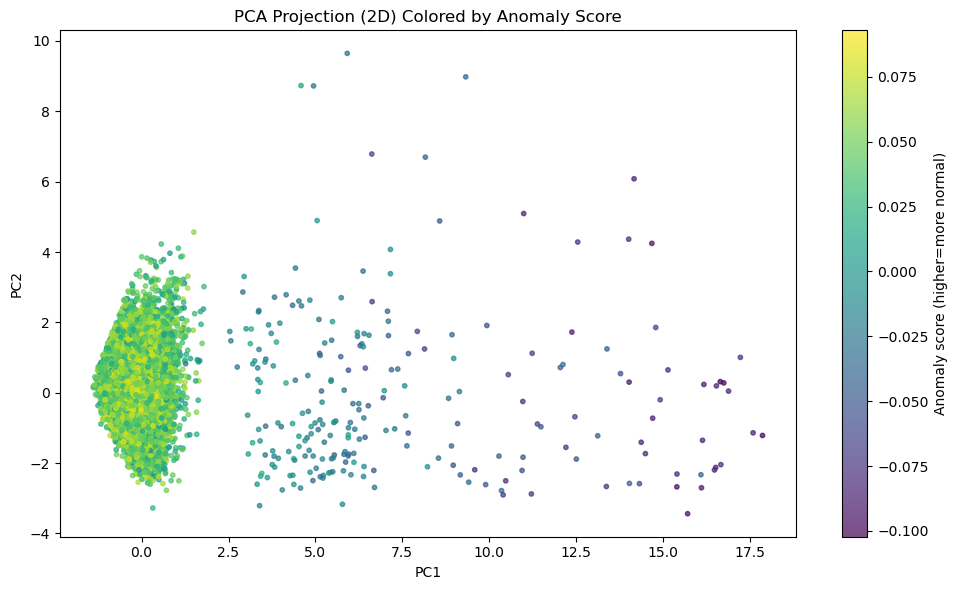

In [19]:

# Optional: Color by anomaly score (continuous)
plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, alpha=0.7, c=df_results["anomaly_score"])
plt.title("PCA Projection (2D) Colored by Anomaly Score")
plt.xlabel("PC1")
plt.ylabel("PC2")
cbar = plt.colorbar()
cbar.set_label("Anomaly score (higher=more normal)")
plt.tight_layout()
plt.show()


### Interpretation (2–3 sentences)

In the PCA projection, normal behavior tends to form a **dense central cloud** because most events share similar time-of-day, low failed-attempt counts, and common user/country/protocol patterns. Predicted anomalies appear as **isolated points or small sparse groups**, often separated because they combine off-hours activity with unusually high failed attempts and rare categorical combinations. This is consistent with the expected structure for brute-force style anomalies.


## Conclusion

This pipeline successfully demonstrates an end-to-end anomaly detection workflow on cybersecurity-like logs. Isolation Forest identifies a small fraction of events as anomalous, primarily driven by **high failed login attempts**, **off-hours timing**, and **unusual categorical combinations** (users/countries/protocols), which align with **MITRE ATT&CK T1110 (Brute Force)**. The 2D PCA visualization shows normal events clustering densely, while anomalies appear more scattered at the edges, supporting the model’s ability to separate rare suspicious behavior from typical activity.
